In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Wed Jan 24 15:37:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   30C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [7]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999

hp.M = hp.n_prior_embeddings

In [8]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [9]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform_notconst_0.999/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 440475, model_list, optimizer_list)

total 0


### Dataset

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [11]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [12]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [13]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

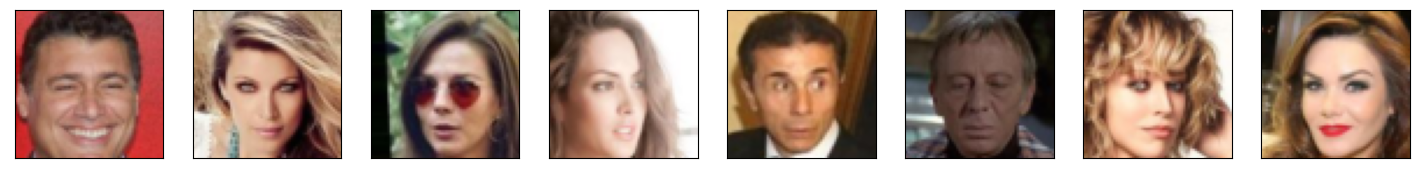

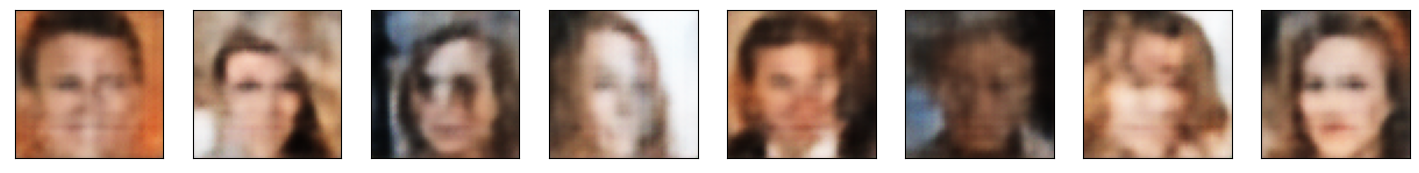

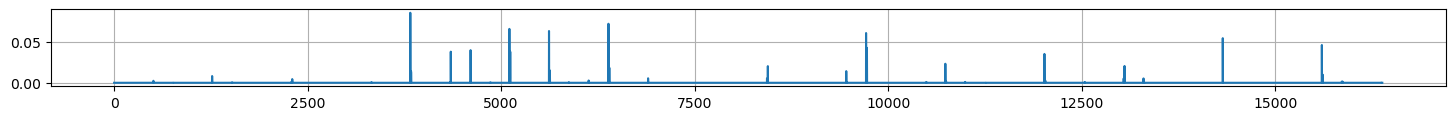

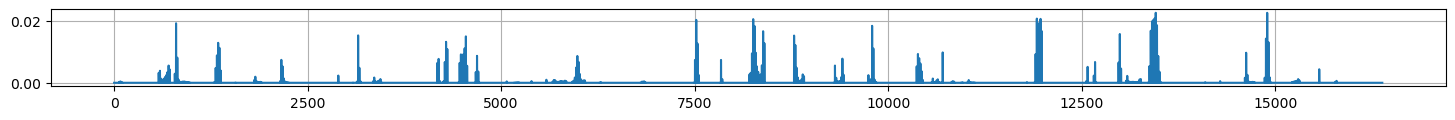

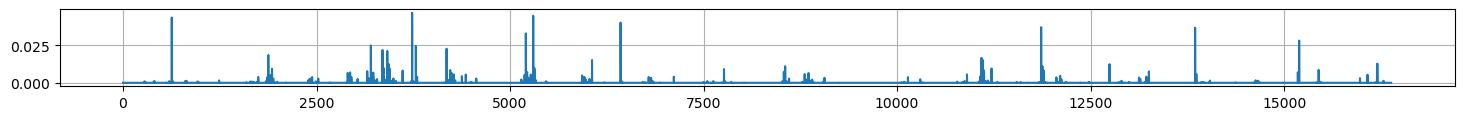

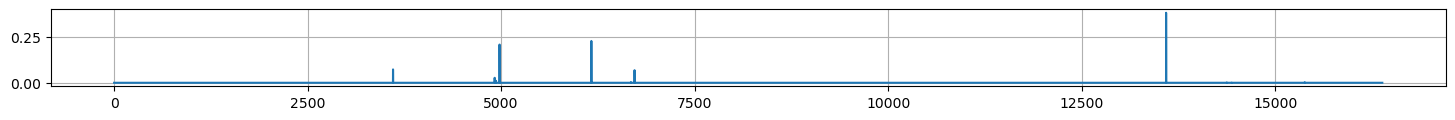

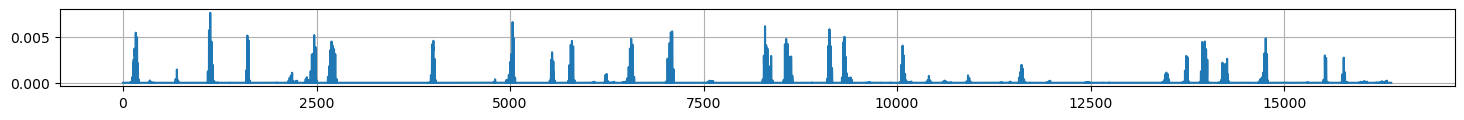

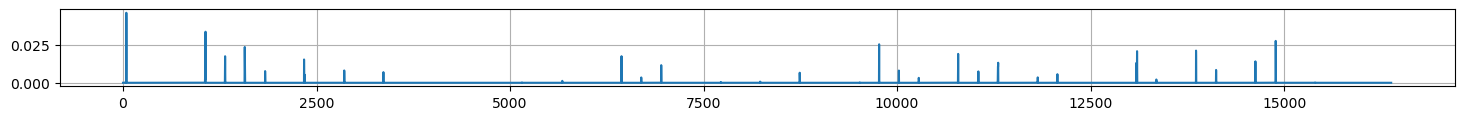

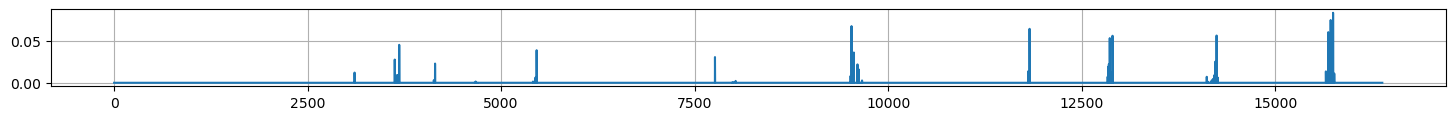

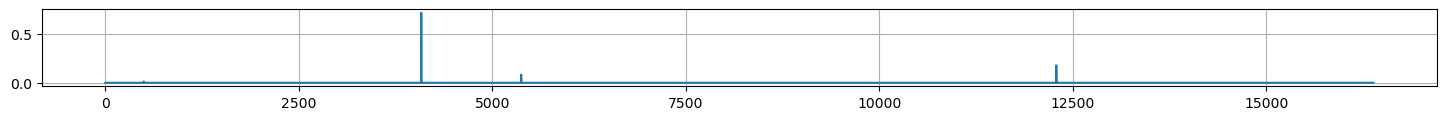

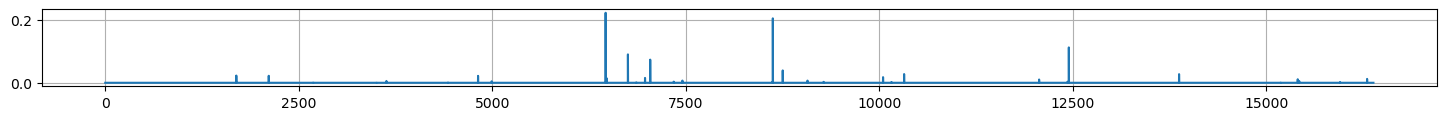

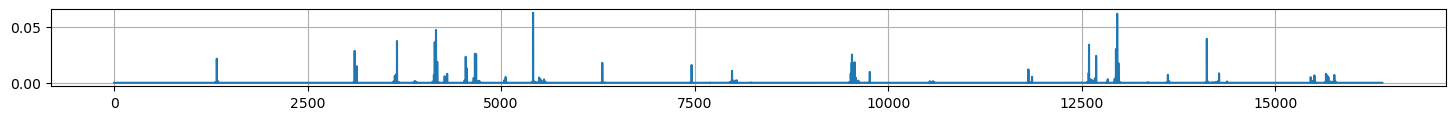

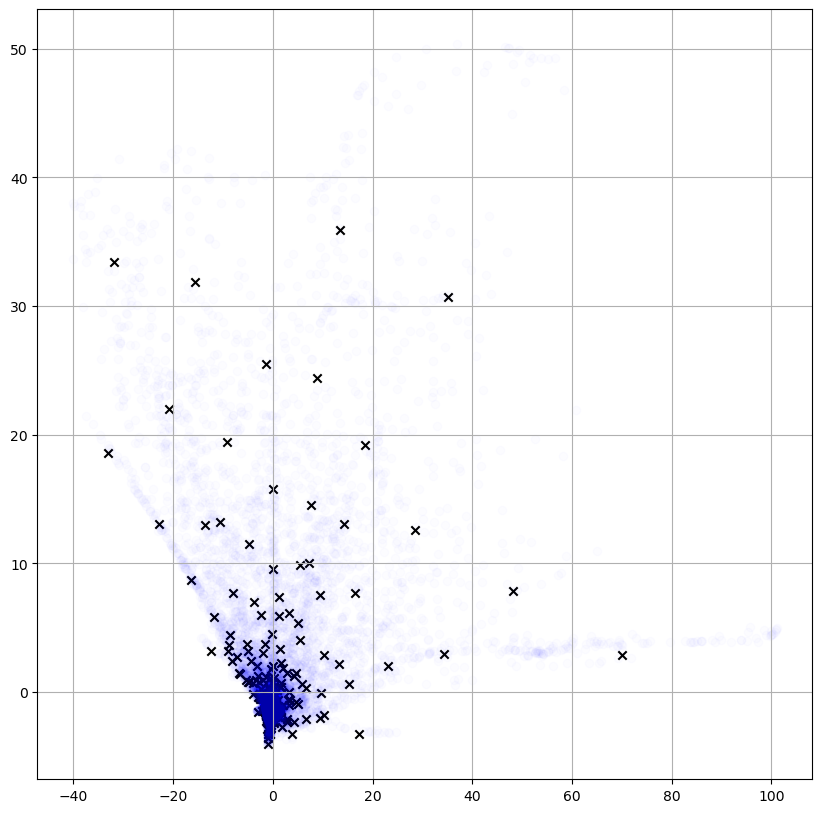

8001
lse_loss -77.85584259033203
commit_loss 0.0693492740392685
recon_loss 0.009850114583969116
8002
lse_loss -77.84319305419922
commit_loss 0.0725090503692627
recon_loss 0.009865442290902138
8003
lse_loss -77.89192199707031
commit_loss 0.07740311324596405
recon_loss 0.00988039467483759
8004
lse_loss -77.95796966552734
commit_loss 0.07062821835279465
recon_loss 0.0090580303221941
8005
lse_loss -77.80068969726562
commit_loss 0.0861605778336525
recon_loss 0.009364924393594265
8006
lse_loss -77.90470886230469
commit_loss 0.09094095975160599
recon_loss 0.009331664070487022
8007
lse_loss -77.88111877441406
commit_loss 0.0743943303823471
recon_loss 0.009046068415045738
8008
lse_loss -77.8149642944336
commit_loss 0.07082383334636688
recon_loss 0.009498263709247112
8009
lse_loss -77.96022033691406
commit_loss 0.07963551580905914
recon_loss 0.009187509305775166
8010
lse_loss -77.96039581298828
commit_loss 0.07231085747480392
recon_loss 0.008983748964965343
8011
lse_loss -77.89678192138672
commi

8088
lse_loss -78.39295959472656
commit_loss 0.10085607320070267
recon_loss 0.009613225236535072
8089
lse_loss -78.3503646850586
commit_loss 0.09298364073038101
recon_loss 0.010896998457610607
8090
lse_loss -78.45909118652344
commit_loss 0.07093043625354767
recon_loss 0.009580799378454685
8091
lse_loss -78.45611572265625
commit_loss 0.09487046301364899
recon_loss 0.009701130911707878
8092
lse_loss -78.37690734863281
commit_loss 0.08107054978609085
recon_loss 0.009077773429453373
8093
lse_loss -78.40471649169922
commit_loss 0.0880906879901886
recon_loss 0.009703029878437519
8094
lse_loss -78.3880386352539
commit_loss 0.09220672398805618
recon_loss 0.01006362121552229
8095
lse_loss -78.4795150756836
commit_loss 0.0758507177233696
recon_loss 0.009722476825118065
8096
lse_loss -78.59082794189453
commit_loss 0.08970607817173004
recon_loss 0.009166695177555084
8097
lse_loss -78.52482604980469
commit_loss 0.07969336956739426
recon_loss 0.009176032617688179
8098
lse_loss -78.5220947265625
comm

lse_loss -79.036865234375
commit_loss 0.0720338523387909
recon_loss 0.009872227907180786
8175
lse_loss -79.01058959960938
commit_loss 0.07721278071403503
recon_loss 0.010066434741020203
8176
lse_loss -79.00084686279297
commit_loss 0.08716228604316711
recon_loss 0.009445182047784328
8177
lse_loss -78.98172760009766
commit_loss 0.10128644853830338
recon_loss 0.010498657822608948
8178
lse_loss -79.08072662353516
commit_loss 0.09013569355010986
recon_loss 0.010469017550349236
8179
lse_loss -79.1021499633789
commit_loss 0.09621866792440414
recon_loss 0.010409283451735973
8180
lse_loss -78.98505401611328
commit_loss 0.08250978589057922
recon_loss 0.010014493018388748
8181
lse_loss -79.08585357666016
commit_loss 0.07549511641263962
recon_loss 0.010559182614088058
8182
lse_loss -79.06475830078125
commit_loss 0.07583491504192352
recon_loss 0.010230145417153835
8183
lse_loss -79.07241821289062
commit_loss 0.0746563971042633
recon_loss 0.010296756401658058
8184
lse_loss -79.05413055419922
commit_

8259
lse_loss -79.6828842163086
commit_loss 0.07318911701440811
recon_loss 0.009300913661718369
8260
lse_loss -79.71636962890625
commit_loss 0.07483707368373871
recon_loss 0.010370428673923016
8261


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.show() 

In [ ]:
from tqdm import tqdm

belongs = []
for i, batch in tqdm(enumerate(train_loader)):
    data = preprocess(batch)

    # Forward
    model.eval()
    data = model(data, latent_temp=1)
    belongs.append(data['belong'])

    if i > 100:
        break

In [ ]:
belongs = torch.stack(belongs, dim=0)
print(belongs.shape)

In [20]:
(belongs.sum(dim=[0, 1]) > 0).sum()

tensor(512, device='cuda:0')